# Find the most similar Census cells in any other data with embeddings vector search

This tutorial demonstrates the experimental API in the Python `cellxgene_census` package to search Census embeddings using [TileDB-Vector-Search](https://github.com/TileDB-Inc/TileDB-Vector-Search) indexes. We will generate [scVI embeddings](https://docs.scvi-tools.org/en/1.0.0/tutorials/notebooks/api_overview.html) for some test cells, search the Census scVI embeddings for nearest neighbors, and use them to predict cell type and tissue of the test cells.

To reproduce this notebook, `pip install 'cellxgene_census[experimental]' scvi-tools` and obtain the [pbmc3k blood cells data](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) and scVI model:

**Contents**

1. Downloading data and Census scVI model.
2. Loading and embedding pbmc3k cells.
3. Search for similar Census cells.
4. Predicting cell metadata.

⚠️ Note that the Census RNA data includes duplicate cells present across multiple datasets. Duplicate cells can be filtered in or out using the cell metadata variable `is_primary_data` which is described in the [Census schema](https://github.com/chanzuckerberg/cellxgene-census/blob/main/docs/cellxgene_census_schema.md#repeated-data).

## Downloading data and Census scVI model

Download the data first. This the 10X PBMC 3K dataset.

In [1]:
import warnings

warnings.filterwarnings("ignore")

import anndata
import cellxgene_census
import cellxgene_census.experimental
import pandas as pd
import scanpy as sc
import scvi

CENSUS_VERSION = "2024-07-01"

Download the test data which will be used to look for their Census most similar cells. This is the test 10X PMBC dataset.

In [2]:
!mkdir -p data
!wget --no-check-certificate -q -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
!tar -xzf data/pbmc3k_filtered_gene_bc_matrices.tar.gz -C data/

Now download the model corresponding to the census version used in the notebook. 

First find S3 location of the model.

In [3]:
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    census = cellxgene_census.open_soma(census_version=CENSUS_VERSION)

    scvi_info = cellxgene_census.experimental.get_embedding_metadata_by_name(
        embedding_name="scvi",
        organism="homo_sapiens",
        census_version=CENSUS_VERSION,
    )

scvi_info["model_link"]

's3://cellxgene-contrib-public/models/scvi/2024-07-01/homo_sapiens/model.pt'

Now use that path to download via HTTPs, make sure to update the URL if you change the Census version.

In [4]:
!mkdir -p scvi-human-2024-07-01
!wget --no-check-certificate -q -O scvi-human-2024-07-01/model.pt https://cellxgene-contrib-public.s3.us-west-2.amazonaws.com/models/scvi/2024-07-01/homo_sapiens/model.pt

## Loading and embedding pbmc3k cells

Load the pmbc3k cell data into an AnnData:

In [5]:
adata = sc.read_10x_mtx("data/filtered_gene_bc_matrices/hg19/", var_names="gene_ids")
adata.var["ensembl_id"] = adata.var.index
adata.obs["n_counts"] = adata.X.sum(axis=1)
adata.obs["joinid"] = list(range(adata.n_obs))
adata.obs["batch"] = "unassigned"

Run them through the scVI forward pass and extract their latent representation (embedding):

In [6]:
scvi.model.SCVI.prepare_query_anndata(adata, "scvi-human-2024-07-01")
vae_q = scvi.model.SCVI.load_query_data(
    adata,
    "scvi-human-2024-07-01",
)

# This allows for a simple forward pass
vae_q.is_trained = True
latent = vae_q.get_latent_representation()
adata.obsm["scvi"] = latent

INFO     File scvi-human-2024-07-01/model.pt already downloaded                                                    
INFO     Found 54.675% reference vars in query data.                                                               
INFO     File scvi-human-2024-07-01/model.pt already downloaded                                                    


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


The scVI embedding vectors for each cell are now stored in the `scvi` obsm layer. Lastly, clean up the AnnData a little:

In [7]:
# filter out missing features
adata = adata[:, adata.var["gene_symbols"].notnull().values].copy()
adata.var.set_index("gene_symbols", inplace=True)
# assign placeholder cell_type and tissue_general labels
adata.var_names = adata.var["ensembl_id"]
adata.obs["cell_type"] = "Query - PBMC 10X"
adata.obs["tissue_general"] = "Query - PBMC 10X"

And for visualization, compute leiden clusters on the scVI embeddings. These will come at handy later on.

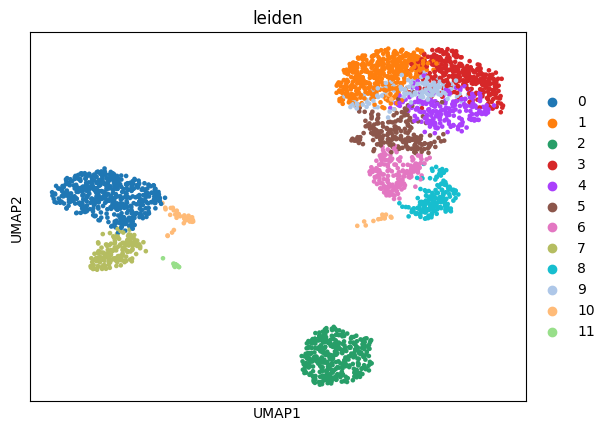

In [8]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep="scvi")
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color="leiden")

## Search for similar Census cells

Use the CELLxGENE Census experimental API to search the vector index of scVI embeddings.

In [9]:
%%time
neighbors = cellxgene_census.experimental.find_nearest_obs(
    "scvi", "homo_sapiens", CENSUS_VERSION, query=adata, k=30, memory_GiB=8, nprobe=20
)

CPU times: user 1min 18s, sys: 1min 3s, total: 2min 22s
Wall time: 44.1 s


This accessed the cell embeddings in the `scvi` obsm layer and searched the latent space for the *k* nearest neighbors (by Euclidean distance) among the Census cell embeddings, returning the distances and obs `soma_joinid`s (*k* for each query cell).

In [10]:
neighbors

NeighborObs(distances=array([[0.15405715, 0.16895768, 0.23857602, ..., 0.3158804 , 0.3161367 ,
        0.31640536],
       [0.29017174, 0.3242963 , 0.34604427, ..., 0.56234425, 0.56352013,
        0.56709266],
       [0.40463728, 0.41439083, 0.4177297 , ..., 0.55779415, 0.56181365,
        0.5627153 ],
       ...,
       [0.19712524, 0.2522816 , 0.2780036 , ..., 0.34790507, 0.34811306,
        0.35188618],
       [0.36992368, 0.3832991 , 0.39696082, ..., 0.560152  , 0.564542  ,
        0.5646585 ],
       [0.33078673, 0.3308513 , 0.35727894, ..., 0.52874607, 0.5310725 ,
        0.53260434]], dtype=float32), neighbor_ids=array([[53938900, 56894874, 53904832, ..., 35431931, 34956866, 53863941],
       [ 6276632, 18807209,  7251536, ..., 12705987, 11951694, 11980870],
       [16903285, 21674180, 50898826, ..., 35424173, 44145922, 36066801],
       ...,
       [36336282, 52999747, 53523979, ..., 54143971, 53062159, 46403244],
       [36217923, 46782331, 35719817, ..., 54091908, 46313955, 4

To explore these results, fetch an AnnData with each query cell's (single) nearest neighbor in scVI's latent space, including their embedding vectors:

In [11]:
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    neighbors_adata = cellxgene_census.get_anndata(
        census,
        "homo_sapiens",
        "RNA",
        obs_coords=sorted(neighbors.neighbor_ids[:, 0].tolist()),
        obs_embeddings=["scvi"],
        X_name="normalized",
        column_names={"obs": ["soma_joinid", "tissue", "tissue_general", "cell_type"]},
    )
neighbors_adata.var_names = neighbors_adata.var["feature_id"]

Make a UMAP visualization of these nearest neighbors:

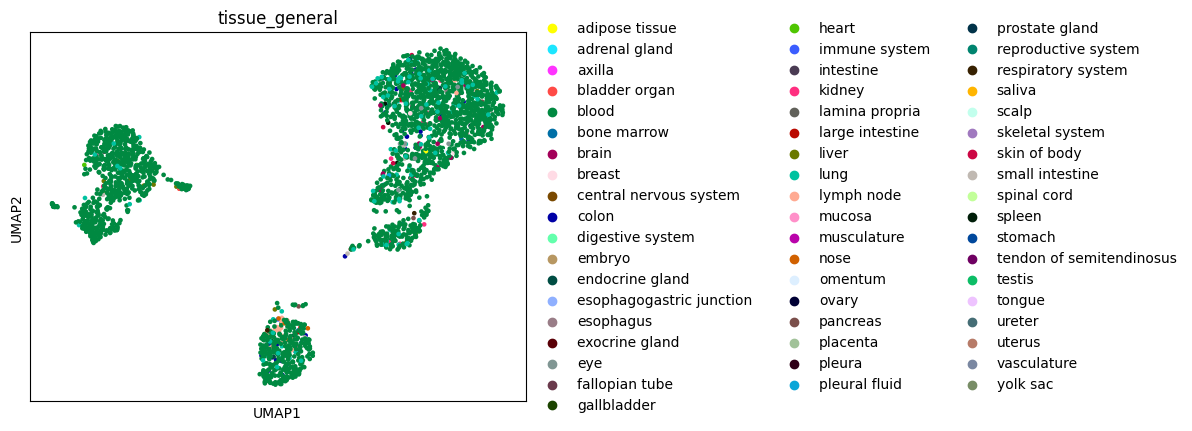

In [12]:
sc.pp.neighbors(neighbors_adata, n_neighbors=15, use_rep="scvi")
sc.tl.umap(neighbors_adata)
sc.pl.umap(neighbors_adata, color="tissue_general")

As expected, the nearest neighbors are largely Census blood cells, with some distinct cell type clusters.

Now display the pbmc3k query cells together with their Census nearest neighbors:

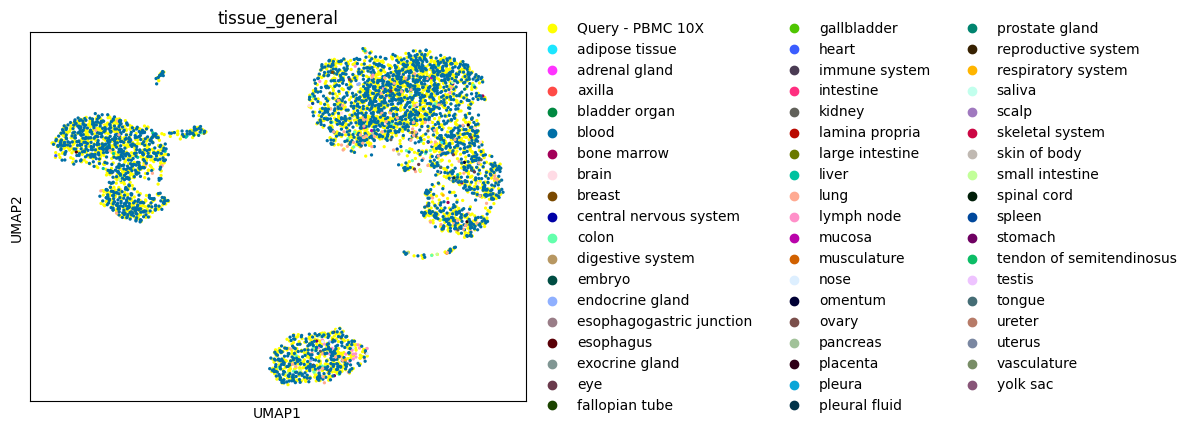

In [13]:
adata_concat = anndata.concat([adata, neighbors_adata])
sc.pp.neighbors(adata_concat, n_neighbors=15, use_rep="scvi")
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=["tissue_general"])

The neighbor clusters appear to correspond to cell type heterogeneity also present in the query.

## Predicting cell metadata

The experimental API also has a method to predict metadata attributes of the query cells, like `tissue_general` and `cell_type`, based on the Census nearest neighbors.

In [14]:
predictions = cellxgene_census.experimental.predict_obs_metadata(
    "homo_sapiens", CENSUS_VERSION, neighbors, ["tissue_general", "cell_type"]
)
predictions

,tissue_general,tissue_general_confidence,cell_type,cell_type_confidence
0,blood,0.866667,"CD4-positive, alpha-beta T cell",0.366667
1,lymph node,0.366667,B cell,0.433333
2,blood,0.966667,"central memory CD4-positive, alpha-beta T cell",0.266667
3,blood,0.900000,classical monocyte,0.733333
4,blood,0.900000,natural killer cell,0.633333
...,...,...,...,...
2695,blood,0.800000,classical monocyte,0.600000
2696,immune system,0.366667,plasmablast,0.566667
2697,blood,0.966667,B cell,0.633333
2698,blood,0.866667,B cell,0.600000


Unlike the above visualizations of *single* nearest neighbors, these predictions are informed by each query cell's *k*=30 neighbors, with an attached confidence score.

These predictions can be added to the original AnnData object for visualization.

In [15]:
predictions.index = adata.obs.index
predictions = predictions.rename(columns={"cell_type": "predicted_cell_type"})
adata.obs = pd.concat([adata.obs, predictions], axis=1)

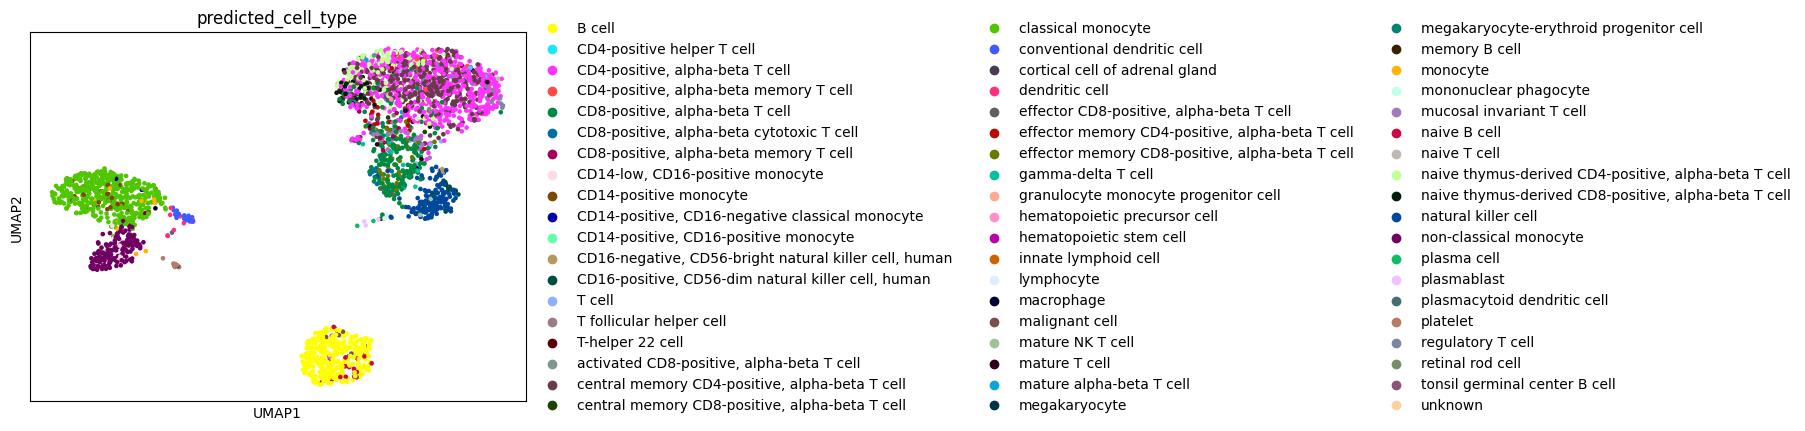

In [16]:
sc.pl.umap(adata, color="predicted_cell_type")

Now the leiden clusters calculated at the beginning can be annotated by popular vote, whereby each cluster gets assigned the most common predicted cell type from the previous step.

In [17]:
adata.obs["predicted_consolidated_cell_type"] = ""
for leiden_cluster in adata.obs["leiden"].drop_duplicates():
    most_popular_type = (
        adata.obs.loc[adata.obs["leiden"] == leiden_cluster,].value_counts("predicted_cell_type").index[0]
    )
    adata.obs.loc[adata.obs["leiden"] == leiden_cluster, "predicted_consolidated_cell_type"] = most_popular_type

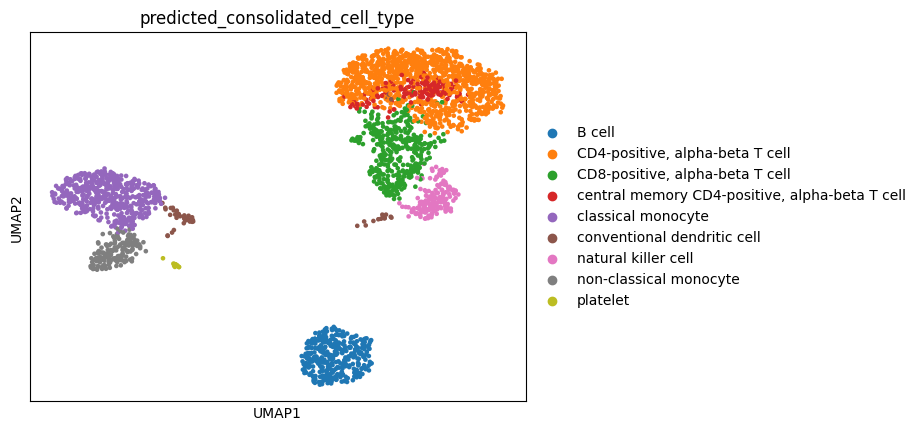

In [18]:
sc.pl.umap(adata, color="predicted_consolidated_cell_type")